# Example4 - Multisetup with Pre Global Estimation Re-scaling (PreGER) method

In this example, we'll be working with a simulated dataset generated from a finite element model of a fictitious three-story, L-shaped building. This model was created using OpenSeesPy, and the corresponding Python script can be found [here](https://github.com/dagghe/pyOMA-test-data/blob/main/test_data/3SL/model.py). 

As always, first we import the necessary modules. All the files needed to run this example are available [here](https://github.com/dagghe/pyOMA-test-data/tree/main/test_data/3SL).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyoma2.algorithms import SSI_MS, FDD_MS
from pyoma2.setup import MultiSetup_PreGER
from pyoma2.support.utils.sample_data import get_sample_data

In the **preGER** merging procedure, the datasets will not be processed indipendently once at the time and merged at the end as for the **PoSER** procedure, but rather merged during the analysis process of each algorithm. 
The first step involves instantiating the ```MultiSetup_PreGER``` class and passing the list of datasets, the lists of reference sensors, and their sampling frequency. Similarly to the single setup class, also for the ```MultiSetup_PreGER``` we have access to a wide set of tools to pre-process the data and get more information regarding its quality (e.g. ```decimate_data()```, ```filter_data()```, ```plot_ch_info()``` methods).

2025-06-09 11:05:52,084 - pyoma2.support.utils.sample_data - INFO - set1.npy already exists locally. (sample_data:49)
2025-06-09 11:05:52,087 - pyoma2.support.utils.sample_data - INFO - set2.npy already exists locally. (sample_data:49)
2025-06-09 11:05:52,090 - pyoma2.support.utils.sample_data - INFO - set3.npy already exists locally. (sample_data:49)


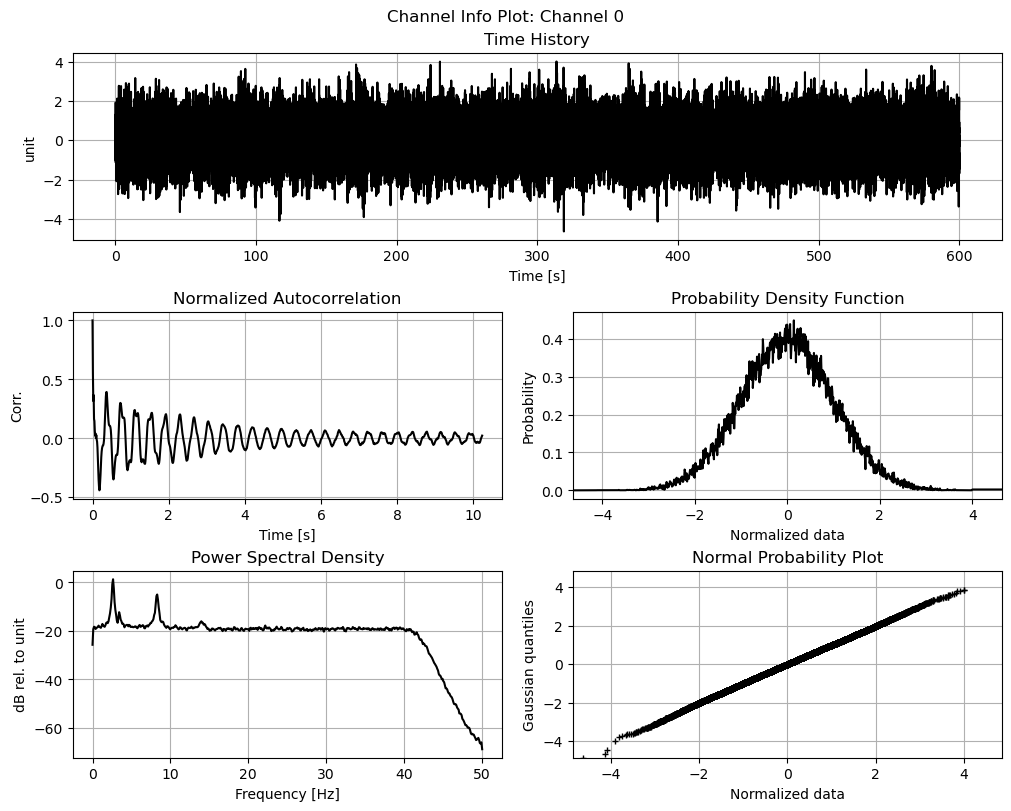

In [2]:
# import data files
set1 = np.load(get_sample_data(filename="set1.npy", folder="3SL"), allow_pickle=True)
set2 = np.load(get_sample_data(filename="set2.npy", folder="3SL"), allow_pickle=True)
set3 = np.load(get_sample_data(filename="set3.npy", folder="3SL"), allow_pickle=True)

# list of datasets and reference indices
data = [set1, set2, set3]
ref_ind = [[0, 1, 2], [0, 1, 2], [0, 1, 2]]

# Create multisetup
msp = MultiSetup_PreGER(fs=100, ref_ind=ref_ind, datasets=data)

# decimate data
#msp.decimate_data(q=2)

# Plot TH, PSD and KDE of the (selected) channels of the (selected) datasets
_, _ = msp.plot_ch_info(data_idx=[1], ch_idx=[2])

Again if we want to be able to plot the mode shapes later, then we need to define the geometry of the structure. 

In [3]:
# Geometry 1
_geo1 = get_sample_data(filename="Geo1.xlsx", folder="3SL")
# Geometry 2
_geo2 = get_sample_data(filename="Geo2.xlsx", folder="3SL")

# Define geometry1
msp.def_geo1_by_file(_geo1)
# Define geometry 2
msp.def_geo2_by_file(_geo2)

2025-06-09 11:05:52,557 - pyoma2.support.utils.sample_data - INFO - Geo1.xlsx already exists locally. (sample_data:49)
2025-06-09 11:05:52,559 - pyoma2.support.utils.sample_data - INFO - Geo2.xlsx already exists locally. (sample_data:49)


Now we need to instantiate the multi-setup versions of the algorithms we wish to execute, such as SSIcov.

2025-06-09 11:05:52,720 - pyoma2.setup.base - INFO - Running SSIcov... (base:123)
100%|██████████| 101/101 [00:00<00:00, 15591.06it/s]
2025-06-09 11:05:53,489 - pyoma2.functions.ssi - INFO - Calculating modal parameters for increasing model order... (ssi:628)
100%|██████████| 51/51 [00:00<00:00, 326.15it/s]
2025-06-09 11:05:53,808 - pyoma2.setup.base - INFO - Running FDD... (base:123)
100%|██████████| 3/3 [00:00<00:00, 21.91it/s]
2025-06-09 11:05:53,977 - pyoma2.setup.base - INFO - all done (base:102)


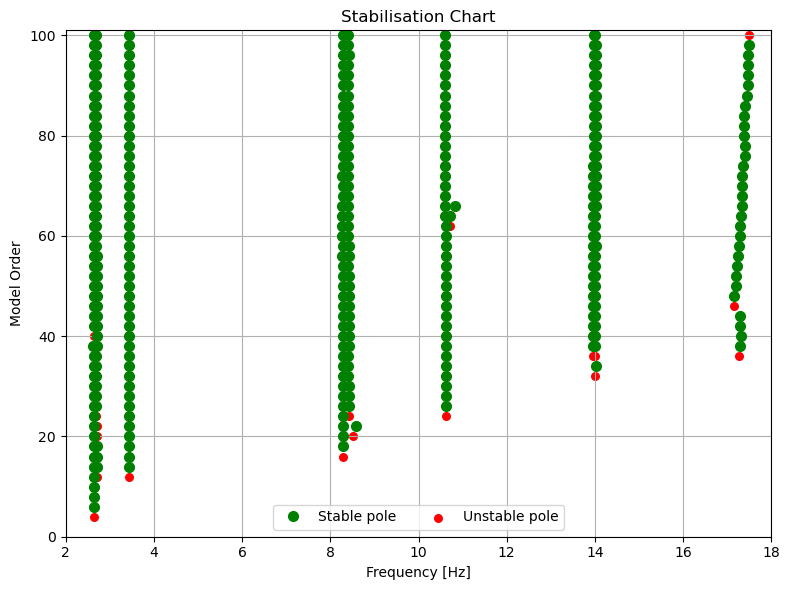

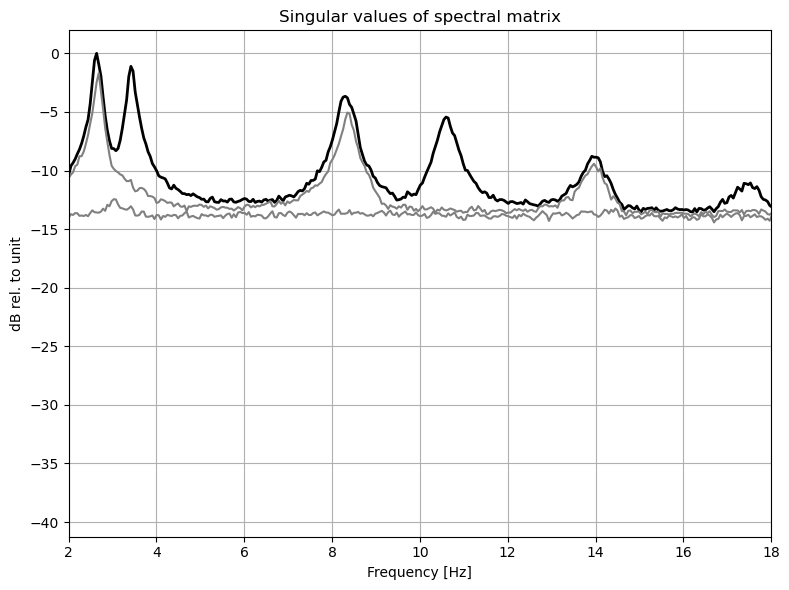

In [4]:
# Initialise the algorithms
ssicov = SSI_MS(name="SSIcov", method="cov", br=80, ordmax=100, step=2)
fdd = FDD_MS(name="FDD", nxseg=2**11)

# Add algorithms to the class
msp.add_algorithms(ssicov)
msp.add_algorithms(fdd)
msp.run_all()

# Plot
_, _ = ssicov.plot_stab(freqlim=(2,18), hide_poles=False)
_, _ = fdd.plot_CMIF(freqlim=(2,18))

After the algorithms have been executed we can exctract the desired poles and plot the mode shapes.

2025-06-09 11:05:54,139 - pyoma2.setup.base - INFO - Getting mpe modal parameters from SSIcov (base:149)
2025-06-09 11:05:54,140 - pyoma2.functions.ssi - INFO - Extracting SSI modal parameters (ssi:1036)
100%|██████████| 9/9 [00:00<00:00, 34887.93it/s]


Widget(value='<iframe src="http://localhost:55320/index.html?ui=P_0x176c4ac30_0&reconnect=auto" class="pyvista…

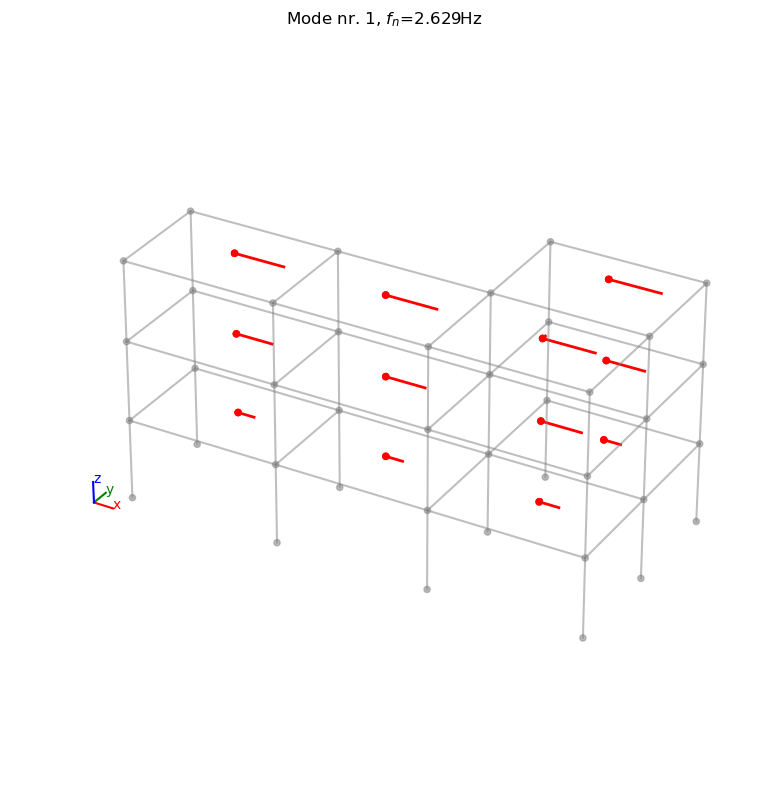

In [5]:
# get modal parameters
msp.mpe(
    "SSIcov",
    sel_freq=[2.63, 2.69, 3.43, 8.29, 8.42, 10.62, 13.95, 14.1, 17.57],
    order_in=80)

# msp.mpe_from_plot("SSIdat")

# plot mode shapes
_, _ = msp.plot_mode_geo1(algo_res=ssicov.result, mode_nr=1, view="3D", scaleF=2)
_ = msp.plot_mode_geo2(algo_res=ssicov.result, mode_nr=6, scaleF=2, notebook=True)

In [6]:
ssicov.result.Fn

array([ 2.62912121,  2.69251536,  3.42725538,  8.27933667,  8.40579279,
       10.61195719, 13.97248961, 14.02437035, 17.3954682 ])